In [1]:
import proplot as plot
import numpy as np
import yaml
import glob
import copy

%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "INFO"))

In [3]:
import tempfile
from pizza_cutter_sims.pizza_cutter import (
    run_des_pizza_cutter_coadding_on_sim,
    make_remapped_se_images_des_pizza_cutter_coadding_on_sim,
)
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect, make_mbobs_from_coadd_data
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.stars import mask_stars


cfg_yaml = """\
shear:
  scene: True

  # these keys are used to build paired sims w/ noise cancellation
  g: 0.02
  swap12: False

  # set these to run a sim directly
  g1: 0.02
  g2: 0.00

msk:
  cosmic_rays: True
  bad_columns: True
  streaks:
    mean_streaks: 0.3
    # min_width: 2
    # max_width: 10
  

coadd:
  central_size: 225
  buffer_size: 25
  scale: 0.263

se:
  n_images: 3
  wcs_config:
    position_angle_range: [0, 360]
    dither_scale: 1  # set to an odd number of pixels
    scale: 0.263
    scale_frac_std: 0.01
    shear_std: 0.01

psf:
  type: galsim.Gaussian
  fwhm: 0.9
  fwhm_frac_std: 0.1
  shear_std: 0.1
  shear: [0, 0]

layout:
  type: hex
  ngal_per_side: 10
  ngal_per_arcmin2: 60
  dither_scale: 0.263

gal:
  type: exp-dim

star:
  dens_factor: 5
  rad_dist: uniform
  interp:
    skip: True
    # these control how the interpolation is applied for star holes
    # if fill_isolated_with_noise is True, then any missing pixel with no non-missing
    # pixels within iso_buff will be filled with noise and then used to interpolate
    # the rest of the pixels.
    iso_buff: 1
    fill_isolated_with_noise: False
  apodize:
    skip: False
    ap_rad: 1
  mask_expand_rad: 16

pizza_cutter:
  skip: False
  single_epoch_config:
    # pixel spacing for building various WCS interpolants
    se_wcs_interp_delta: 10
    coadd_wcs_interp_delta: 25
    frac_buffer: 1.42  # buffer around SE image to account for position angle rotations

    reject_outliers: False
    symmetrize_masking: True
    copy_masked_edges: False
    max_masked_fraction: 1.1
    edge_buffer: 8
    mask_tape_bumps: False

    # set the interp flags to 0 or 3 or 7 to interp stuff in the mask
    spline_interp_flags:
      - 7
    noise_interp_flags:
      - 0

    # always zero
    bad_image_flags:
      - 0

metadetect:
  metacal:
    psf: fitgauss
    types: [noshear, 1p, 1m, 2p, 2m]
    use_noise_image: True

  psf:
    lm_pars:
      maxfev: 2000
      ftol: 1.0e-05
      xtol: 1.0e-05
    model: gauss

    # we try many times because if this fails we get no psf info
    # for the entire patch
    ntry: 10

  sx:

  weight:
    fwhm: 1.2  # arcsec

  meds:
    box_padding: 2
    box_type: iso_radius
    max_box_size: 64
    min_box_size: 32
    rad_fac: 2
    rad_min: 4

  maskflags: 33554432  # 2**25 = BMASK_GAIA_STAR from pizza cutter

  # check for an edge hit
  bmask_flags: 1610612736  # 2**29 || 2**30
"""

cfg = yaml.safe_load(cfg_yaml)

In [4]:
rng = np.random.RandomState(seed=342)
rng = np.random.RandomState(seed=34)
seeds = rng.randint(low=1, high=2**29, size=5)

rng = np.random.RandomState(seed=seeds[0])
gal_rng = np.random.RandomState(seed=seeds[1])
coadd_rng = np.random.RandomState(seed=seeds[2])
mdet_rng = np.random.RandomState(seed=seeds[3])
star_rng = np.random.RandomState(seed=seeds[4])

data = generate_sim(
    rng=rng,
    gal_rng=gal_rng,
    coadd_config=cfg["coadd"],
    se_config=cfg["se"],
    psf_config=cfg["psf"],
    gal_config=cfg["gal"],
    star_config=cfg["star"],
    layout_config=cfg["layout"],
    msk_config=cfg["msk"],
    shear_config=cfg["shear"],
    star_rng=star_rng,
    skip_coadding=False
)
assert len(data["stars"]) > 0
assert len(data["stars"]) < 5

with tempfile.TemporaryDirectory() as tmpdir:
    cdata = run_des_pizza_cutter_coadding_on_sim(
        rng=coadd_rng,
        tmpdir=tmpdir,
        single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
        img=data["img"],
        wgt=data["wgt"],
        msk=data["msk"],
        bkg=data["bkg"],
        info=data["info"],
        n_extra_noise_images=0,
    )
    
    resampled_data, _ = make_remapped_se_images_des_pizza_cutter_coadding_on_sim(
        rng=coadd_rng,
        tmpdir=tmpdir,
        single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
        img=data["img"],
        wgt=data["wgt"],
        msk=data["msk"],
        bkg=data["bkg"],
        info=data["info"],    
        n_extra_noise_images=0,
    )
    
    mbobs = make_mbobs_from_coadd_data(
        wcs=data["coadd_wcs"],
        cdata=cdata,
    )

    mask_stars(
        rng=star_rng,
        mbobs=mbobs,
        stars=data["stars"],
        interp_cfg=cfg["star"]["interp"],
        apodize_cfg=cfg["star"]["apodize"],
        mask_expand_rad=cfg["star"]["mask_expand_rad"],
    )
    
    mdet_res = run_metadetect(
        rng=mdet_rng,
        config=cfg["metadetect"],
        mbobs=mbobs,
    )

INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch1/epoch1
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch2/epoch2
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 3
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:pre-processing image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:pre-processing image epoch1/epoch1
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:pre-processing image epoch2/epoch2
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:resampling image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:resampling image epoch1/epoch1
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:

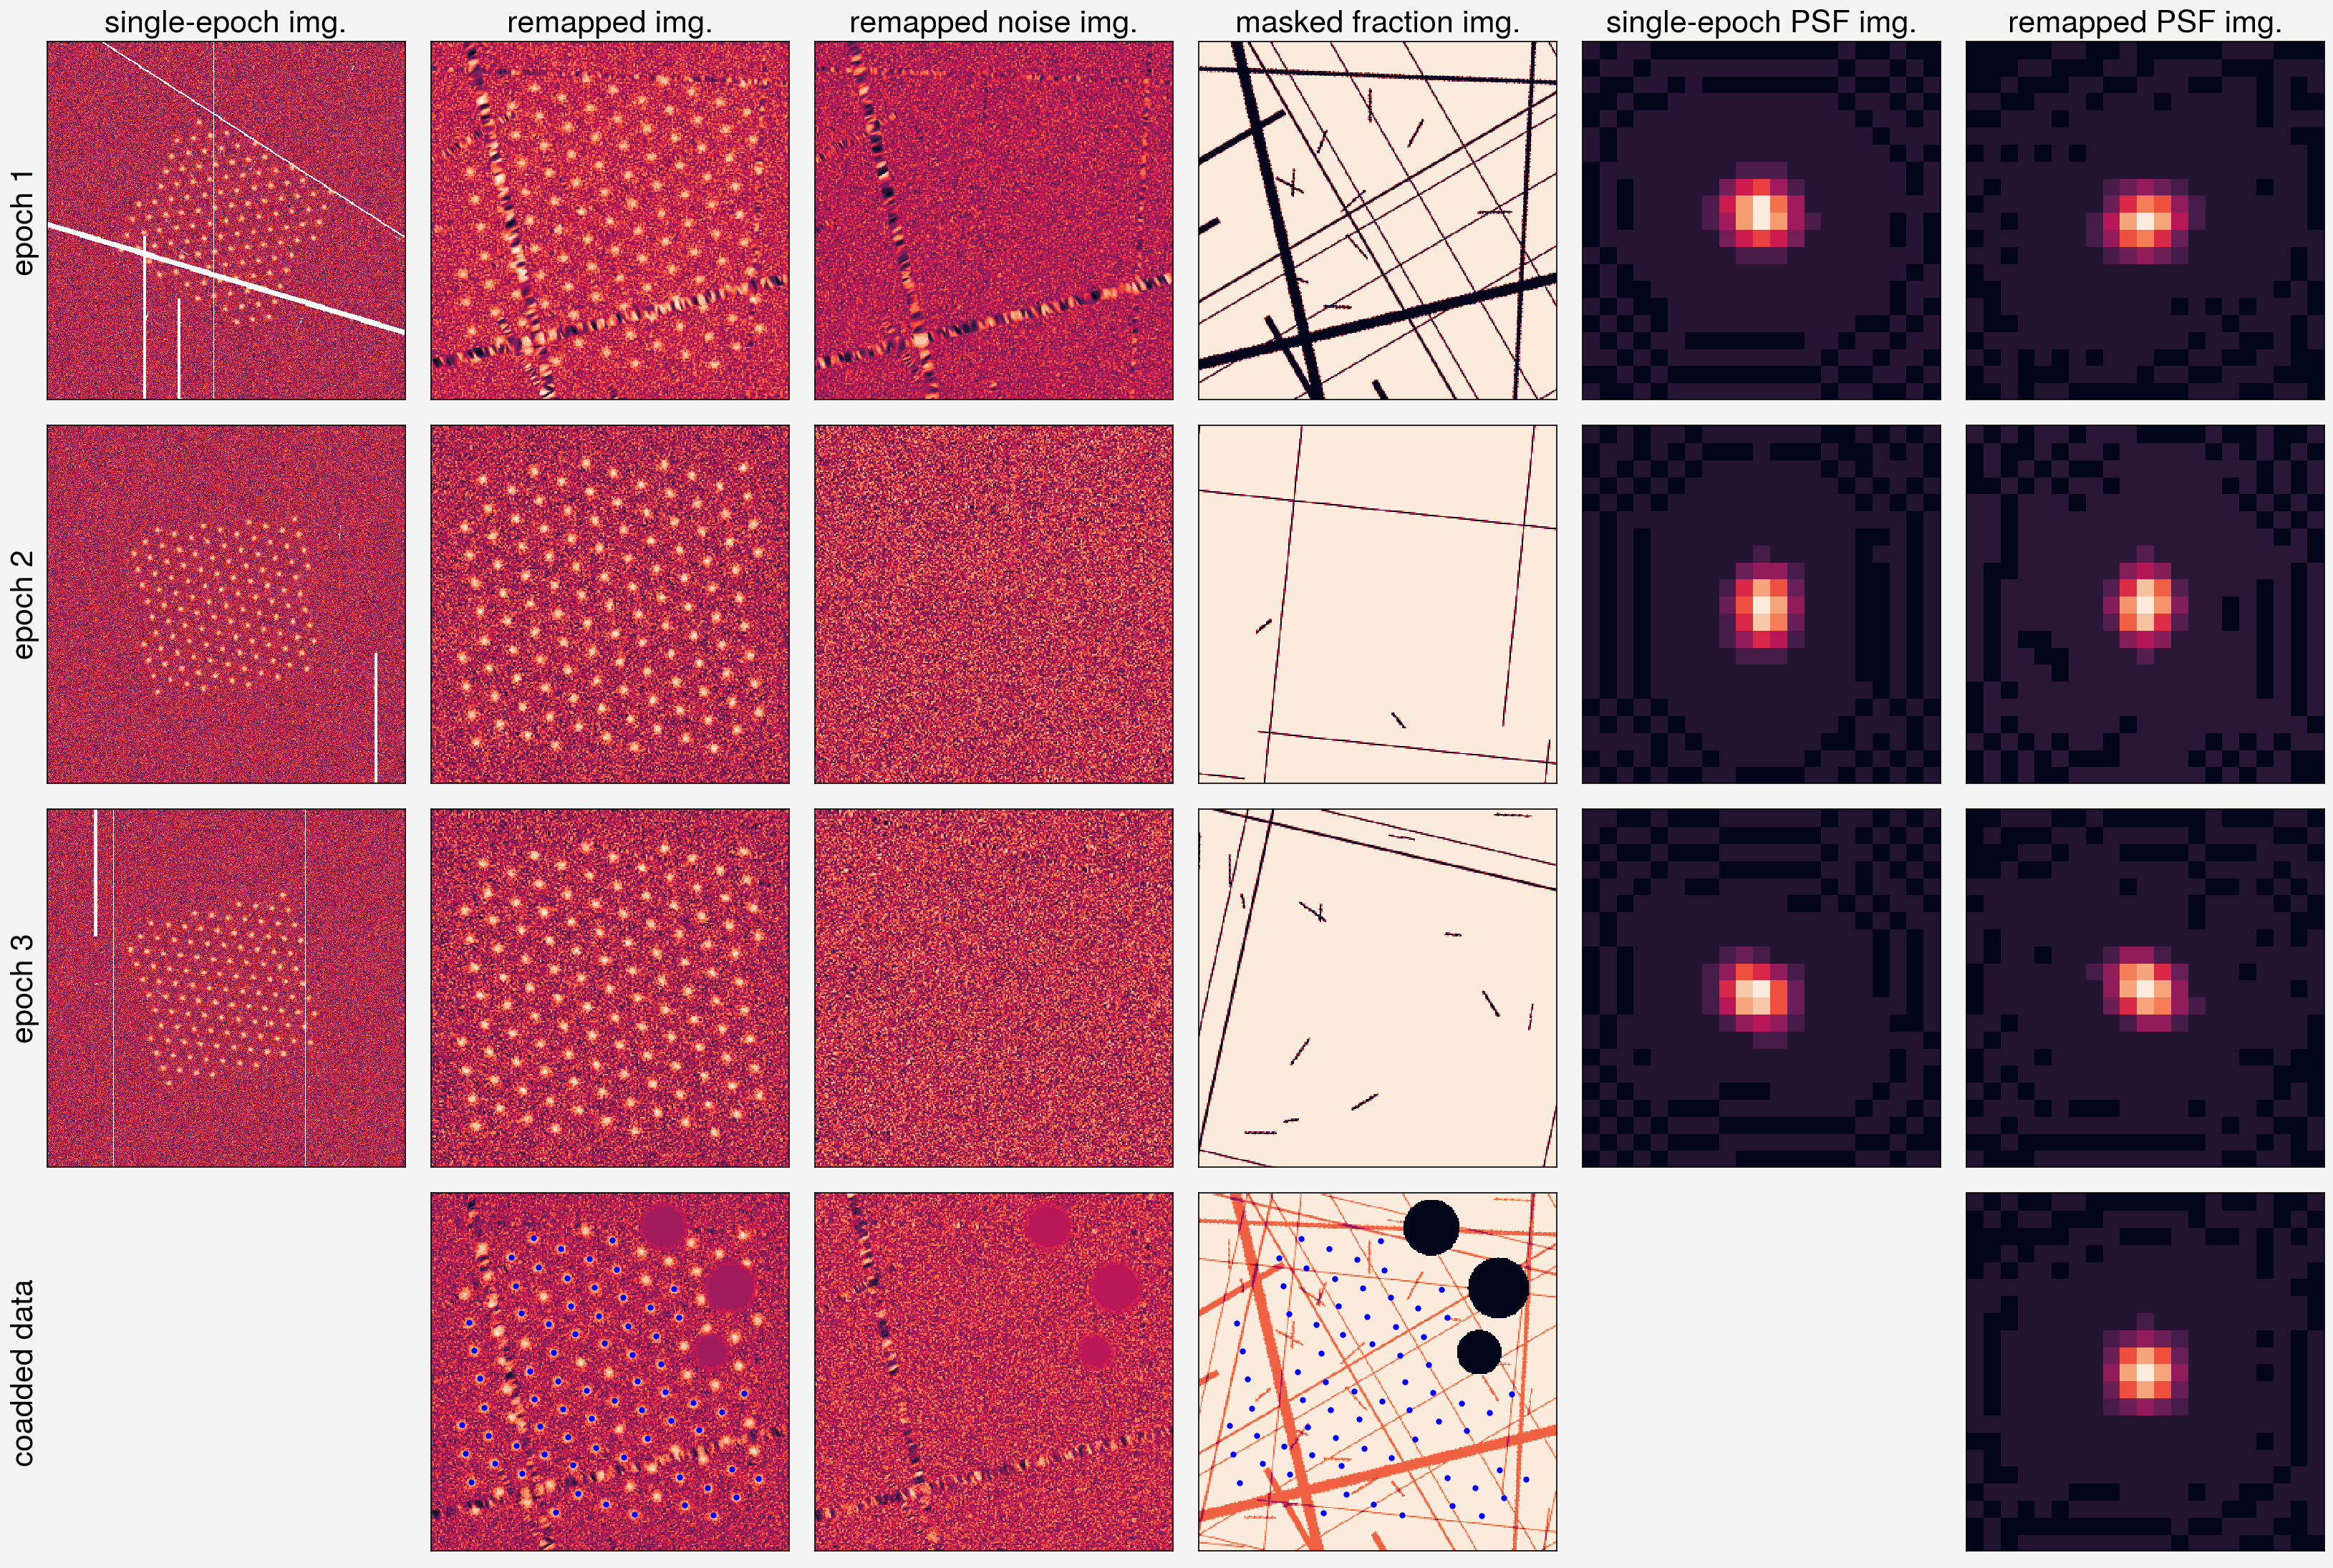

In [5]:
psf_buff = 15
fig, axs = plot.subplots(nrows=len(data["img"])+1, ncols=6, share=0)

for i in range(len(data["img"])):
    axs[i, 0].pcolormesh(np.arcsinh(data["img"][i]*np.sqrt(data["wgt"][i])), cmap="rocket")
    axs[i, 0].set_aspect(1)

    axs[i, 1].pcolormesh(
        np.arcsinh(
            resampled_data[i]["image"]/np.std(resampled_data[i]["noises"][0])
        ), 
        cmap="rocket",
    )
    axs[i, 1].set_aspect(1)
    
    axs[i, 2].pcolormesh(
        np.arcsinh(
            resampled_data[i]["noises"][0]/np.std(resampled_data[i]["noises"][0])
        ), 
        cmap="rocket",
    )
    axs[i, 2].set_aspect(1)

    axs[i, 3].pcolormesh(
        resampled_data[i]["interp_frac"],
        cmap="rocket_r",
        vmin=0,
        vmax=1,
    )
    axs[i, 3].set_aspect(1)

    axs[i, 4].pcolormesh(
        resampled_data[i]["single_epoch_psf"],
        cmap="rocket",
    )
    axs[i, 4].set_aspect(1)
    
    axs[i, 5].pcolormesh(
        resampled_data[i]["psf"][psf_buff:-psf_buff, psf_buff:-psf_buff],
        cmap="rocket",
    )
    axs[i, 5].set_aspect(1)


if False:
    ### coadd with no stars
    i = 3
    axs[i, 0].set_frame_on(False)
    axs[i, 4].axis("off")
    axs[i, 1].pcolormesh(
            np.arcsinh(
                cdata["image"]/np.std(cdata["noise"])
            ), 
            cmap="rocket",
        )
    axs[i, 1].set_aspect(1)

    axs[i, 2].pcolormesh(
            np.arcsinh(
                cdata["noise"]/np.std(cdata["noise"])
            ), 
            cmap="rocket",
        )
    axs[i, 2].set_aspect(1)

    axs[i, 3].pcolormesh(
        cdata["mfrac"],
        cmap="rocket_r",
        vmin=0,
        vmax=1,
    )
    axs[i, 3].set_aspect(1)

    axs[i, 5].pcolormesh(
        cdata["psf"][psf_buff:-psf_buff, psf_buff:-psf_buff],
        cmap="rocket",
    )
    axs[i, 5].set_aspect(1)


### coadd with star masking
i = len(data["img"])
axs[i, 0].set_frame_on(False)
axs[i, 4].axis("off")
axs[i, 1].pcolormesh(
        np.arcsinh(
            mbobs[0][0].image/np.std(mbobs[0][0].noise)
        ), 
        cmap="rocket",
    )
ms = 4
msk = (
    (mdet_res["noshear"]["flags"] == 0)
    & (mdet_res["noshear"]["wmom_s2n"] >= 10)
    & (mdet_res["noshear"]["wmom_T_ratio"] >= 1.2)
    & (mdet_res["noshear"]["mfrac"] <= 0.1)
)
axs[i, 1].plot(
    mdet_res["noshear"]["sx_col"][msk],
    mdet_res["noshear"]["sx_row"][msk],
    ".",
    color="blue",
    markersize=ms,
)
axs[i, 1].set_aspect(1)
axs[i, 1].set_xlim(0, mbobs[0][0].image.shape[0])


axs[i, 2].pcolormesh(
        np.arcsinh(
            mbobs[0][0].noise/np.std(mbobs[0][0].noise)
        ), 
        cmap="rocket",
    )
axs[i, 2].set_aspect(1)

axs[i, 3].pcolormesh(
    mbobs[0][0].mfrac,
    cmap="rocket_r",
    vmin=0,
    vmax=1,
)
msk = (
    (mdet_res["noshear"]["flags"] == 0)
    & (mdet_res["noshear"]["wmom_s2n"] >= 10)
    & (mdet_res["noshear"]["wmom_T_ratio"] >= 1.2)
    & (mdet_res["noshear"]["mfrac"] <= 0.1)
)
axs[i, 3].plot(
    mdet_res["noshear"]["sx_col"][msk],
    mdet_res["noshear"]["sx_row"][msk],
    ".",
    color="blue",
    markersize=ms,
)
axs[i, 3].set_xlim(0, mbobs[0][0].image.shape[0])
axs[i, 3].set_ylim(0, mbobs[0][0].image.shape[0])

axs[i, 3].set_aspect(1)

axs[i, 5].pcolormesh(
    cdata["psf"][psf_buff:-psf_buff, psf_buff:-psf_buff],
    cmap="rocket",
)
axs[i, 5].set_aspect(1)


## set axes
for ax in np.ravel(axs):
    ax.format(xlocator='null', ylocator='null')
    
fs = 'xx-large'
axs[0, 0].set_title("single-epoch img.", fontsize=fs)
axs[0, 1].set_title("remapped img.", fontsize=fs)
axs[0, 2].set_title("remapped noise img.", fontsize=fs)
axs[0, 3].set_title("masked fraction img.", fontsize=fs)
axs[0, 4].set_title("single-epoch PSF img.", fontsize=fs)
axs[0, 5].set_title("remapped PSF img.", fontsize=fs)

axs[0, 0].set_ylabel("epoch 1", fontsize=fs)
axs[1, 0].set_ylabel("epoch 2", fontsize=fs)
axs[2, 0].set_ylabel("epoch 3", fontsize=fs)
axs[3, 0].set_ylabel("coadded data", fontsize=fs)
# axs[4, 0].set_ylabel("coadded data", fontsize=fs)


# for i in range(1, axs.shape[1]):
#     for j in range(axs.shape[0]-1):
#         # axs[j, i].xaxis.set_visible(False)
#         axs[j, i].yaxis.set_visible(False)

fig.savefig("allsteps.png", dpi=200)